Proje : Koronavirüs aşıları hakkındaki görüşlerin duygu analizinin doğal dil işleme ile yapılması.

Gerekli kütüphanelerin yüklenmesi

In [2]:
from textblob import TextBlob
from textblob import Word
from sklearn import model_selection, preprocessing, linear_model, naive_bayes,metrics
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn import decomposition, ensemble

import pandas, xgboost, numpy, textblob, string, nltk
from nltk.corpus import stopwords
from keras.preprocessing import  text, sequence
from keras import layers, models, optimizers

import numpy as np
from numpy.linalg import norm

import warnings 
warnings.filterwarnings("ignore")


In [3]:
import pandas as pd
data = pd.read_csv("Covishield_tweets.csv")
print(data.shape)
data.head()

(9999, 6)


,Unnamed: 0,Time,From-User,From-User-Id,Text,Retweet-Count
0,0,1/23/21 11:23 AM,Aditya Raj Kaul,44425241,"#BREAKING: India to send over 300,000 Covishie...",675.0
1,1,1/23/21 11:40 AM,Saket Gokhale,24857905,India cleared commercial exports of Covid-19 v...,762.0
2,2,1/22/21 6:12 PM,Adar Poonawalla,911182427782909952,Thank you Shri Uddhav Ji @CMOMaharashtra and @...,529.0
3,3,1/23/21 6:17 PM,??,2787411518,RT @abdulla_shahid: Maldives is happy to recei...,784.0
4,4,1/23/21 6:17 PM,Dr Vijay Chauthaiwale,75489786,RT @DrJankii: As per National Vaccination plan...,888.0


Data Manipulations

In [4]:
data = data.iloc[:,1:]
data

,Time,From-User,From-User-Id,Text,Retweet-Count
0,1/23/21 11:23 AM,Aditya Raj Kaul,44425241,"#BREAKING: India to send over 300,000 Covishie...",675.0
1,1/23/21 11:40 AM,Saket Gokhale,24857905,India cleared commercial exports of Covid-19 v...,762.0
2,1/22/21 6:12 PM,Adar Poonawalla,911182427782909952,Thank you Shri Uddhav Ji @CMOMaharashtra and @...,529.0
3,1/23/21 6:17 PM,??,2787411518,RT @abdulla_shahid: Maldives is happy to recei...,784.0
4,1/23/21 6:17 PM,Dr Vijay Chauthaiwale,75489786,RT @DrJankii: As per National Vaccination plan...,888.0
...,...,...,...,...,...
9994,1/21/21 4:16 PM,Amrik Singh,1155391751240089601,@ians_india Please clear... they approached fo...,0.0
9995,1/21/21 4:16 PM,? Nepal Communist Party??,2751926250,RT @Lunabs8: Covishield fact sheet ??? https:/...,10.0
9996,1/21/21 4:15 PM,????? ?.,26728479,RT @mpeer: Fire breaks out at Serum Institute ...,5.0
9997,1/21/21 4:15 PM,Artborntoshine@,996762919613313024,RT @SanjayBragta: A massive fire broke out at ...,185.0


In [5]:
data = data[~data.Text.duplicated()]
data.index = np.arange(len(data))
data.head()

,Time,From-User,From-User-Id,Text,Retweet-Count
0,1/23/21 11:23 AM,Aditya Raj Kaul,44425241,"#BREAKING: India to send over 300,000 Covishie...",675.0
1,1/23/21 11:40 AM,Saket Gokhale,24857905,India cleared commercial exports of Covid-19 v...,762.0
2,1/22/21 6:12 PM,Adar Poonawalla,911182427782909952,Thank you Shri Uddhav Ji @CMOMaharashtra and @...,529.0
3,1/23/21 6:17 PM,??,2787411518,RT @abdulla_shahid: Maldives is happy to recei...,784.0
4,1/23/21 6:17 PM,Dr Vijay Chauthaiwale,75489786,RT @DrJankii: As per National Vaccination plan...,888.0


Text Prerocessing

In [6]:
def transform(df):
    
    df = df.apply(lambda x: " ".join(x.lower() for x in x.split()))
    df = df.str.replace('[^\w\s]', '')
    df = df.str.replace('\d','')
    sw = stopwords.words('english')
    df = df.apply(lambda x: " ".join(x for x in x.split() if x not in sw))
    delete = pd.Series(' '.join(df).split()).value_counts()[-1000:]
    df = df.apply(lambda x: " ".join(x for x in x.split() if x not in delete))
    df = df.apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

    return df
text = transform(data.Text)


In [7]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

sentiments = []

for t in text:

    sentiment_scores = sid.polarity_scores(t)
    compound_score = sentiment_scores['compound']

    if compound_score > 0.05:
        sentiments.append("Positive")
    elif compound_score < -0.05:
        sentiments.append("Negative")
    else:
        sentiments.append("Neutral")




In [8]:
df = pd.DataFrame({"Text": text, "Sentiment": sentiments})
df.head()

,Text,Sentiment
0,breaking india send covishield vaccine srilank...,Neutral
1,india cleared commercial export covid vaccine ...,Negative
2,thank shri uddhav ji cmomaharashtra authackera...,Negative
3,rt abdulla_shahid maldives happy receive grant...,Positive
4,rt drjankii per national vaccination plan ive ...,Neutral


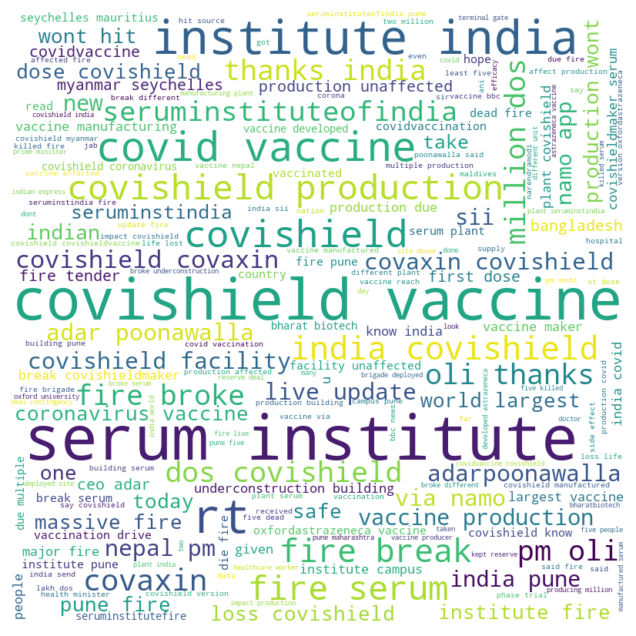

In [13]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
txt = " "
for i in range(len(df.Text)-1):
    txt += df.Text[i] + "\n" + df.Text[i+1]
print(txt)

wordcloud = WordCloud(width=800, height=800, background_color='white').generate(txt)

plt.figure(figsize=(8, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.show()


Variable Engineering
*   Count Vectors
* TF-IDF Vectors (words, characters, n-grams)
*   Word Embeddings


In [14]:
df

,Text,Sentiment
0,breaking india send covishield vaccine srilank...,Neutral
1,india cleared commercial export covid vaccine ...,Negative
2,thank shri uddhav ji cmomaharashtra authackera...,Negative
3,rt abdulla_shahid maldives happy receive grant...,Positive
4,rt drjankii per national vaccination plan ive ...,Neutral
...,...,...
2142,rt ankpopat breaking pune fire break serum ins...,Negative
2143,fire break seruminstituteofindia facility pune...,Negative
2144,httpstcoiqdzfrlnis fire unlikely affect produc...,Negative
2145,ians_india please clear approached siis covish...,Positive


In [15]:
train_x, test_x, train_y, test_y = model_selection.train_test_split(df["Text"],df["Sentiment"],random_state = 1)
train_y[:6]

1048    Positive
2135    Positive
259     Negative
1705    Negative
708      Neutral
1839    Negative
Name: Sentiment, dtype: object

In [18]:
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
test_y = encoder.fit_transform(test_y)
train_y[:5]

array([2, 2, 0, 0, 1])

Count Vectors

In [29]:
vectorizer = CountVectorizer()
vectorizer.fit(train_x)
x_train_count = vectorizer.transform(train_x)
x_test_count = vectorizer.transform(test_x)
print(vectorizer.get_feature_names()[0:5])
x_train_count.toarray()

['_atanas_', '_inthistogether', '_jammunews_', '_p', '_pd']


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

### TF-IDF

In [22]:
tf_idf_word_vectorizer = TfidfVectorizer()
tf_idf_word_vectorizer.fit(train_x)
x_train_tf_idf_word = tf_idf_word_vectorizer.transform(train_x)
x_test_tf_idf_word = tf_idf_word_vectorizer.transform(test_x)
tf_idf_word_vectorizer.get_feature_names()[0:5]

['_atanas_', '_inthistogether', '_jammunews_', '_p', '_pd']

In [23]:
x_train_tf_idf_word.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### ngram level tf-idf

In [24]:
tf_idf_ngram_vectorizer = TfidfVectorizer(ngram_range = (2,3))
tf_idf_ngram_vectorizer.fit(train_x)

TfidfVectorizer(ngram_range=(2, 3))

In [25]:
x_train_tf_idf_ngram = tf_idf_ngram_vectorizer.transform(train_x)
x_test_tf_idf_ngram = tf_idf_ngram_vectorizer.transform(test_x)

### characters level tf-idf

In [26]:
tf_idf_chars_vectorizer = TfidfVectorizer(analyzer = "char", ngram_range = (2,3))
tf_idf_chars_vectorizer.fit(train_x)

TfidfVectorizer(analyzer='char', ngram_range=(2, 3))

In [27]:
x_train_tf_idf_chars = tf_idf_chars_vectorizer.transform(train_x)
x_test_tf_idf_chars = tf_idf_chars_vectorizer.transform(test_x)

### SENTIMENT CLASSIFICATION WITH ML

LOGISTIC REGRESSION 

In [31]:
loj = linear_model.LogisticRegression()
loj_model = loj.fit(x_train_count, train_y)
accuracy = model_selection.cross_val_score(loj_model, 
                                           x_test_count, 
                                           test_y, 
                                           cv = 10).mean()

print("Count Vectors Accuracy Rate:", accuracy)

Count Vectors Accuracy Rate: 0.7874563242487771


In [43]:
loj = linear_model.LogisticRegression()
loj_model = loj.fit(x_train_tf_idf_word,train_y)
accuracy = model_selection.cross_val_score(loj_model, 
                                           x_test_tf_idf_word, 
                                           test_y, 
                                           cv = 10).mean()

print("Word-Level TF-IDF Accuracy Rate:", accuracy)

Word-Level TF-IDF Accuracy Rate: 0.7615653389238295


In [44]:
loj = linear_model.LogisticRegression()
loj_model = loj.fit(x_train_tf_idf_ngram,train_y)
accuracy = model_selection.cross_val_score(loj_model, 
                                           x_test_tf_idf_ngram, 
                                           test_y, 
                                           cv = 10).mean()

print("N-GRAM TF-IDF Accuracy Rate:", accuracy)

N-GRAM TF-IDF Accuracy Rate: 0.6348008385744235


In [45]:
loj = linear_model.LogisticRegression()
loj_model = loj.fit(x_train_tf_idf_chars,train_y)
accuracy = model_selection.cross_val_score(loj_model, 
                                           x_test_tf_idf_chars, 
                                           test_y, 
                                           cv = 10).mean()

print("CHARLEVEL Accuracy Rate :", accuracy)

CHARLEVEL Accuracy Rate : 0.746366177498253


### Naive Bayes

In [32]:
nb = naive_bayes.MultinomialNB()
nb_model = nb.fit(x_train_tf_idf_word,train_y)
accuracy = model_selection.cross_val_score(nb_model, 
                                           x_test_tf_idf_word, 
                                           test_y, 
                                           cv = 10).mean()

print("Word-Level TF-IDF Accuracy Rate:", accuracy)

Word-Level TF-IDF Accuracy Rate: 0.7130328441649196


In [33]:
nb = naive_bayes.MultinomialNB()
nb_model = nb.fit(x_train_tf_idf_ngram,train_y)
accuracy = model_selection.cross_val_score(nb_model, 
                                           x_test_tf_idf_ngram, 
                                           test_y, 
                                           cv = 10).mean()

print("N-GRAM TF-IDF Accuracy Rate:", accuracy)

N-GRAM TF-IDF Accuracy Rate: 0.6218029350104822


In [34]:
nb = naive_bayes.MultinomialNB()
nb_model = nb.fit(x_train_tf_idf_chars,train_y)
accuracy = model_selection.cross_val_score(nb_model, 
                                           x_test_tf_idf_chars, 
                                           test_y, 
                                           cv = 10).mean()

print("CHARLEVEL Accuracy Rate:", accuracy)

CHARLEVEL Accuracy Rate: 0.5550314465408805


### Random Forests

In [35]:
rf = ensemble.RandomForestClassifier()
rf_model = rf.fit(x_train_count,train_y)
accuracy = model_selection.cross_val_score(rf_model, 
                                           x_test_count, 
                                           test_y, 
                                           cv = 10).mean()

print("Count Vectors Accuracy Rate:", accuracy)

Count Vectors Accuracy Rate: 0.7260307477288609


In [36]:
rf = ensemble.RandomForestClassifier()
rf_model = rf.fit(x_train_tf_idf_word,train_y)
accuracy = model_selection.cross_val_score(rf_model, 
                                           x_test_tf_idf_word, 
                                           test_y, 
                                           cv = 10).mean()

print("Word-Level TF-IDF Accuracy Rate:", accuracy)

Word-Level TF-IDF Accuracy Rate: 0.7504542278127184


In [37]:
rf = ensemble.RandomForestClassifier()
rf_model = loj.fit(x_train_tf_idf_ngram,train_y)
accuracy = model_selection.cross_val_score(rf_model, 
                                           x_test_tf_idf_ngram, 
                                           test_y, 
                                           cv = 10).mean()

print("N-GRAM TF-IDF Accuracy Rate:", accuracy)

N-GRAM TF-IDF Accuracy Rate: 0.6348008385744235


In [38]:
rf = ensemble.RandomForestClassifier()
rf_model = loj.fit(x_train_tf_idf_chars,train_y)
accuracy = model_selection.cross_val_score(rf_model, 
                                           x_test_tf_idf_chars, 
                                           test_y, 
                                           cv = 10).mean()

print("CHARLEVEL Accuracy Rate:", accuracy)

CHARLEVEL Accuracy Rate: 0.746366177498253


### XGBoost

In [39]:
xgb = xgboost.XGBClassifier()
xgb_model = xgb.fit(x_train_count,train_y)
accuracy = model_selection.cross_val_score(xgb_model, 
                                           x_test_count, 
                                           test_y, 
                                           cv = 10).mean()

print("Count Vectors Accuracy Rate:", accuracy)

Count Vectors Axccuracy Rate: 0.7167365478686234


In [40]:
xgb = xgboost.XGBClassifier()
xgb_model = xgb.fit(x_train_tf_idf_word,train_y)
accuracy = model_selection.cross_val_score(xgb_model, 
                                           x_test_tf_idf_word, 
                                           test_y, 
                                           cv = 10).mean()

print("Word-Level TF-IDF Accuracy Rate:", accuracy)

Word-Level TF-IDF Accuracy Rate: 0.7263102725366876


In [41]:
xgb = xgboost.XGBClassifier()
xgb_model = xgb.fit(x_train_tf_idf_ngram,train_y)
accuracy = model_selection.cross_val_score(xgb_model, 
                                           x_test_tf_idf_ngram, 
                                           test_y, 
                                           cv = 10).mean()

print("N-GRAM TF-IDF Accuracy Rate:", accuracy)

N-GRAM TF-IDF Accuracy Rate: 0.6236547868623341


In [42]:
xgb = xgboost.XGBClassifier()
xgb_model = xgb.fit(x_train_tf_idf_chars,train_y)
accuracy = model_selection.cross_val_score(xgb_model, 
                                           x_test_tf_idf_chars, 
                                           test_y, 
                                           cv = 10).mean()

print("CHARLEVEL Accuracy Rate:", accuracy)

CHARLEVEL Accuracy Rate: 0.7391684136967156
